<a href="https://colab.research.google.com/github/noahruiz416/Tempe_Traffic_Classification/blob/main/Tempe_Traffic_Prototype_Feature_Engineering_Model_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook will contain feature engineering approaches that we will base of the V1 feature engineering notebook. Additionally this notebook will try to narrow down a final model, or at the very least get closer to doing so.

## Installing Initial Dependencies

In [ ]:
!pip install category_encoders
!pip install catboost 
!pip install imblearn

In [2]:
#importing initial libraires
import pandas as pd
import numpy as np 
from category_encoders import CountEncoder
from category_encoders import SumEncoder

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Cleaning Functions, used to load and clean our initial pandas dataframe

In [4]:
#loading in dataframe
df = pd.read_csv("traffic_data.2.csv")

In [5]:
#function to binary encode accidents as fatal or nonfatal
def encode_fatal_accidents(data):
  Severity = []
  for row in data['Injuryseverity']:
    if row != "Fatal":
      Severity.append(0) #nonfatal
    if row == "Fatal":
      Severity.append(1) #fatal
  data['Fatal_Non_Fatal'] = Severity

#this function turns our categorical variables into dummy variables
def nominal_encoding(data):
  data = [['StreetName','Collisionmanner', 'Lightcondition', 'Weather', 'SurfaceCondition']] 
  data_dummies = pd.get_dummies(data)
  return data_dummies

def drop_useless_cols(data):
  return_data = data.drop(labels = ['X', 'Y',
                      'Incidentid', 'DateTime', 'Year',
                       'Latitude', 'Longitude', 'Totalinjuries',
                       'Totalfatalities', 'Injuryseverity', 'Distance', 'OBJECTID', 'Age_Drv1', 'Age_Drv2'], axis = 1)
  return return_data


In [6]:
#helper function that contains the logic for whether or not drugs were involved in an accident
def label_drugs(row):
  if row['DrugUse_Drv1'] == "Drugs" or row['DrugUse_Drv2'] == "Drugs":
    return 1 #drugs are involved
  if row['DrugUse_Drv1'] != "Drugs" or row['DrugUse_Drv2'] != "Drugs":
    return 0 #drugs are not involved

#helper function that contains the logic for whether or not alch was involved in an accident
def label_alchol(row):
  if row['AlcoholUse_Drv1'] == "Drugs" or row['AlcoholUse_Drv2'] == "Drugs":
    return 1 #drugs are involved
  if row['AlcoholUse_Drv1'] != "Drugs" or row['AlcoholUse_Drv2'] != "Drugs":
    return 0 #drugs are not involved

def apply_drug_alchol_label(input_data):
  data1 = input_data['drugs_involved'] = input_data.apply (lambda row: label_drugs(row), axis=1)
  data1 = input_data['alcohol_involved'] = input_data.apply (lambda row: label_alchol(row), axis=1)

In [7]:
#this function drops bad columns in light conditions, violations and collisionmanner
def drop_useless_rows(input_data):
  data1 = input_data[input_data['Lightcondition'].str.contains("51")==False]
  data2 = data1[data1['Lightcondition'].str.contains("Unknown 51")==False]
  data3 = data2[data2['Violation1_Drv1'].str.contains("108")==False]
  data4 = data3[data3['Violation1_Drv1'].str.contains("109")==False]
  data5 = data4[data4['Violation1_Drv1'].str.contains("49")==False]
  data6 = data5[data5['Collisionmanner'].str.contains("10")==False]
  return data6

In [8]:
#this function removes outlier driving ages in the data_set and then calculates the median age between the two drivers and creates a new column
def age_manipulation(input_data):
  data = input_data.drop(input_data.index[input_data['Age_Drv1'] >= 100], inplace=False)
  data1 = data.drop(data.index[data['Age_Drv2'] >= 100], inplace=False)
  data1['median_age'] = (data1['Age_Drv1'] + data1['Age_Drv2']) / 2
  return data1


In [9]:
#function to call all the cleaning methods at once
def clean_dataset(input_data):
  input_data_rows_dropped = drop_useless_rows(input_data)
  age_manipulated_data = age_manipulation(input_data_rows_dropped)
  return age_manipulated_data

## Additional Functions

In [10]:
#takes in a training dataset and encodes it into a frequency encoding
def freq_code(train_data):
  #seperating features into categorical and numerical
  cat_features_input = train_data.select_dtypes(['object'])
  numerical_features_input = train_data.select_dtypes(['int', 'float'])

  #encoding cat_features
  encdoer = CountEncoder(return_df = True)
  cat_features_input_encoded = encdoer.fit_transform(cat_features_input)

  #concat df back together
  converted_data = pd.concat([numerical_features_input, cat_features_input_encoded], axis =1)

  return converted_data 

In [11]:
def drop_more_cols(data):
  return_data = data.drop(labels = ['AlcoholUse_Drv1', 'AlcoholUse_Drv2', 'DrugUse_Drv1', 'DrugUse_Drv2'], axis = 1)
  return return_data

In [204]:
#converts datetime column into a categorical variable for catboost
def time(x):
    x=pd.to_datetime(x,format='%H:%M:%S')
    if pd.to_datetime('03:00:00') < x <= pd.to_datetime('11:00:00'):
        return 'Early'
    elif pd.to_datetime('11:00:00') < x <= pd.to_datetime('17:00:00'):
        return 'Mid-day'
    return 'Late'

## Cleaning our Initial Dataframe. This section takes in a 'dirty' dataframe and outputs an input dataframe as predictors and labels as our target.

In [12]:
#the encode function simply creates our binary labels for fatal or non fatal accidents
encode_fatal_accidents(df)

#setting our clean dataset equal to our cleaned and encoded dataframe
clean_dat = clean_dataset(df)

#dropping useless cols within the clean dataset
clean_dat2_all = drop_useless_cols(clean_dat)

#applying drug and alchol labels
apply_drug_alchol_label(clean_dat2_all)
clean_dat2_all.dropna(inplace=True)

#having our initial input vector of all values into one dataframe
input_vector = clean_dat2_all.drop(labels = ['Fatal_Non_Fatal'], axis = 1)


#we then load the data into to different dataframes one with our input vector and the other with train/test labels
X = input_vector
y = clean_dat2_all['Fatal_Non_Fatal']

#After Creating Our Initial Dataframe, we will create two copies, one encoded with count frequencies and the other engineered to be compatible with catboost

In [13]:
from sklearn.model_selection import train_test_split

## Count Frequency Implementation


In [ ]:
#simple test train split
x_train_freq, x_test_freq, y_train_freq, y_test_freq = train_test_split(input_vector, y, random_state=0, test_size = .20)

In [ ]:
#breaking into two different freq sets one for test and one for train
x_train_freq = freq_code(x_train_freq)
x_test_freq = freq_code(x_test_freq)

#dropping more useless columns in this case the drug and alchol ones related to drivers
x_train_freq = drop_more_cols(x_train_freq)
x_test_freq = drop_more_cols(x_test_freq)

x_freq_all = freq_code(drop_more_cols(input_vector))

## Cat Boost Implementation


In [ ]:
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(input_vector, y, random_state=0, test_size = .20)

#dropping more useless columns in this case the drug and alchol ones related to drivers for cat boost data
x_train_cat = drop_more_cols(x_train_cat)
x_test_cat = drop_more_cols(x_test_cat)

x_cat_all = drop_more_cols(input_vector)

categorical_features_indices = np.where(x_train_cat.dtypes != float)[0]

## With our two seperate areas we can now run baseline models with feature selection methods

### Pipeline Implementation and Baseline model training

In [14]:
#pipelines
from sklearn.pipeline import Pipeline

#models for pipelines
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier

#metric measurements
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay

In [15]:
#function to use as a metric scorer
def metric_scoring(classifier, x_test_data, y_test_data):
  y_true = y_test_data
  y_pred = classifier.predict(x_test_data)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  metric_data = {
      'Precision' : precision,
      'Recall' : recall,
      'Accuracy': accuracy,
      'F1 Score': f1
  }
  return metric_data

In [ ]:
pipe_rf= Pipeline([('rf_classifier',RandomForestClassifier())])
pipe_gb= Pipeline([('gradient_boost_classifier',GradientBoostingClassifier())])
pipe_ada= Pipeline([('ada_boost_classifier',AdaBoostClassifier())])
pipe_lr= Pipeline([('lr_classifier',LogisticRegression(random_state=0))])

pipelines = [pipe_rf, pipe_gb, pipe_ada, pipe_lr]

In [ ]:
for pipe in pipelines[0:4]:
  pipe.fit(x_train_freq, y_train_freq)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
#random forest metrics
metric_scoring(pipelines[0],x_test_freq, y_test_freq)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.997685542354575,
 'F1 Score': 0.0,
 'Precision': 0.0,
 'Recall': 0.0}

In [ ]:
#gradient boosting metrics
metric_scoring(pipelines[1],x_test_freq, y_test_freq)

{'Accuracy': 0.9970683536491283,
 'F1 Score': 0.09523809523809522,
 'Precision': 0.16666666666666666,
 'Recall': 0.06666666666666667}

In [ ]:
#adaboost metrics
metric_scoring(pipelines[2],x_test_freq, y_test_freq)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.997685542354575,
 'F1 Score': 0.0,
 'Precision': 0.0,
 'Recall': 0.0}

In [ ]:
#logistic regression metrics 
metric_scoring(pipelines[3],x_test_freq, y_test_freq)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Accuracy': 0.997685542354575,
 'F1 Score': 0.0,
 'Precision': 0.0,
 'Recall': 0.0}

In [ ]:
#now we will train the cat boost 
catBoost = CatBoostClassifier()

catBoost.fit(
    x_train_cat, y_train_cat, cat_features=categorical_features_indices, 
    plot=True)

In [ ]:
#metrics for CatBoost
metric_scoring(catBoost,x_test_cat, y_test_cat)

{'Accuracy': 0.9978398395309366,
 'F1 Score': 0.125,
 'Precision': 1.0,
 'Recall': 0.06666666666666667}

### Visualizing Metrics with Confusion Matrix 

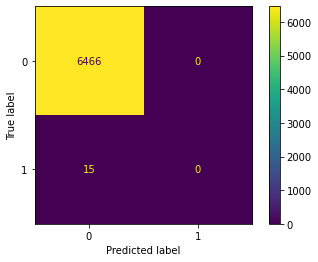

In [ ]:
#rf matrix
ConfusionMatrixDisplay.from_estimator(pipelines[0], x_test_freq, y_test_freq)

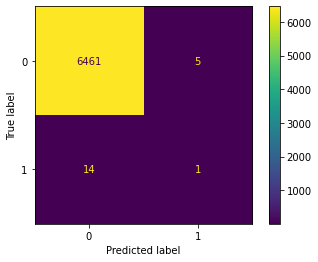

In [ ]:
#gradient boost matrix
ConfusionMatrixDisplay.from_estimator(pipelines[1], x_test_freq, y_test_freq)

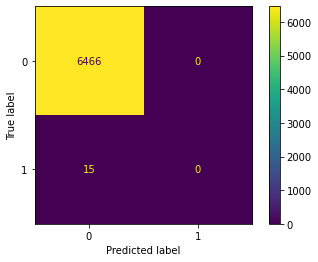

In [ ]:
#ada boost matrix
ConfusionMatrixDisplay.from_estimator(pipelines[2], x_test_freq, y_test_freq)

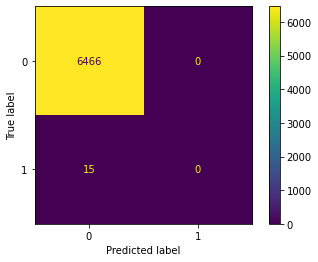

In [ ]:
#logistic
ConfusionMatrixDisplay.from_estimator(pipelines[3], x_test_freq, y_test_freq)

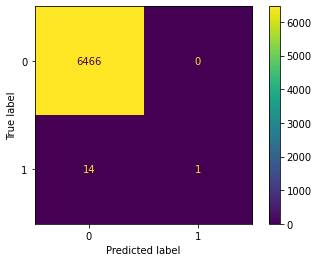

In [ ]:
#cat boost matrix
ConfusionMatrixDisplay.from_estimator(catBoost, x_test_cat, y_test_cat)

### Visualizing Metrics with ROC Curve 

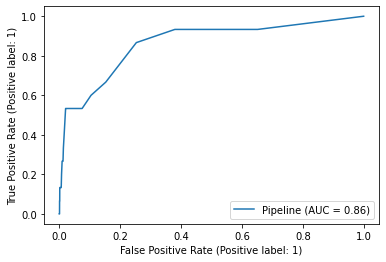

In [ ]:
#rf ROC Curve
RocCurveDisplay.from_estimator(pipelines[0], x_test_freq, y_test_freq)

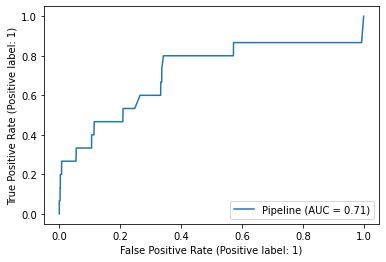

In [ ]:
#gradient boost ROC Curve
RocCurveDisplay.from_estimator(pipelines[1], x_test_freq, y_test_freq)

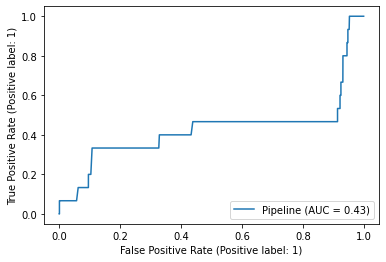

In [ ]:
#ada boost ROC Curve
RocCurveDisplay.from_estimator(pipelines[2], x_test_freq, y_test_freq)

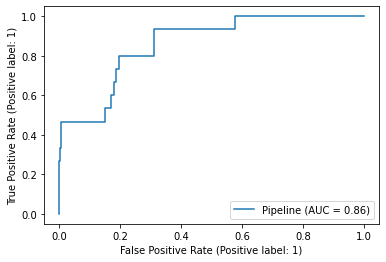

In [ ]:
#logistic ROC Curve
RocCurveDisplay.from_estimator(pipelines[3], x_test_freq, y_test_freq)

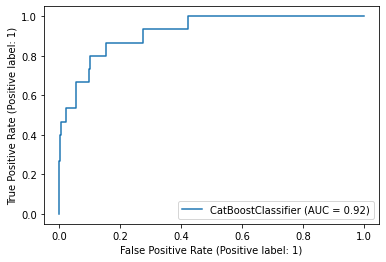

In [ ]:
#cat boost ROC Curve
RocCurveDisplay.from_estimator(catBoost, x_test_cat, y_test_cat)

### CatBoost and Gradient Boost have best out of box performance, now we will focus on tailoring features, and then running under and over sampling methods.

In [16]:
#feature engineering using built in weights derived from both gradient and cat boost
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


In [ ]:
gb = GradientBoostingClassifier()
gb.fit(x_train_freq, y_train_freq)

<Figure size 20000x10000 with 0 Axes>

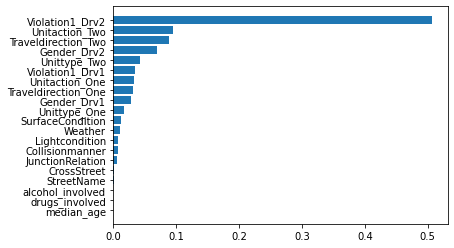

<Figure size 20000x10000 with 0 Axes>

In [ ]:
gb_features = gb.feature_importances_
plt.barh(x_train_freq.columns, sorted(gb.feature_importances_))
figure(figsize=(40, 20), dpi=500)

<Figure size 20000x10000 with 0 Axes>

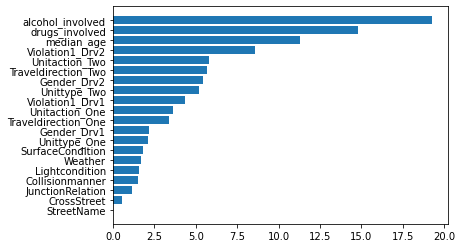

<Figure size 20000x10000 with 0 Axes>

In [ ]:
#feature importance by index for cat boosting
cat_features = catBoost.feature_importances_
plt.barh(x_train_cat.columns, sorted(catBoost.feature_importances_))
figure(figsize=(40, 20), dpi=500)

### Gradient Boost Sparse Iteration 2, sparse model

In [ ]:
#based on the feature importance found from catboost and gradient boosting, we will now create a reduced model, to see if an increase in performance occurs, additionally we will take out gender, as I hypothesize that it may not add much value
#first we will do the sparse gradient boosted model 
x_train_freq, x_test_freq, y_train_freq, y_test_freq = train_test_split(input_vector, y, random_state=0, test_size = .20)

In [ ]:
x_train_freq = freq_code(x_train_freq)
x_train_freq = drop_more_cols(x_train_freq)

In [ ]:
#dropping gender and sparse features
x_train_freq.drop(columns = ['Gender_Drv1', 'Gender_Drv2','JunctionRelation', 
                             'Collisionmanner', 'Lightcondition',
                             'Weather', 'SurfaceCondition', 'Unittype_One', 
                             'Traveldirection_One', 'Unitaction_One', 'Violation1_Drv1', 
                             'Unittype_Two', 'CrossStreet', 'StreetName', 'alcohol_involved', 
                             'median_age'], axis = 1, inplace = True)

In [ ]:
gb_sparse = GradientBoostingClassifier()

gb_sparse.fit(x_train_freq, y_train_freq)

GradientBoostingClassifier()

In [ ]:
#prepping test data
x_test_freq = freq_code(x_test_freq)
x_test_freq = drop_more_cols(x_test_freq)

#dropping gender and sparse features
x_test_freq.drop(columns = ['Gender_Drv1', 'Gender_Drv2','JunctionRelation', 
                             'Collisionmanner', 'Lightcondition',
                             'Weather', 'SurfaceCondition', 'Unittype_One', 
                             'Traveldirection_One', 'Unitaction_One', 'Violation1_Drv1', 
                             'Unittype_Two', 'CrossStreet', 'StreetName', 'alcohol_involved', 
                             'median_age'], axis = 1, inplace = True)

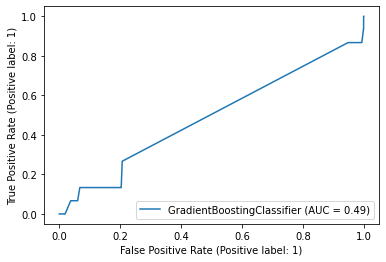

In [ ]:
#checking ROC Curve from sparse model
#sparse model does considerably worse
RocCurveDisplay.from_estimator(gb_sparse, x_test_freq, y_test_freq)

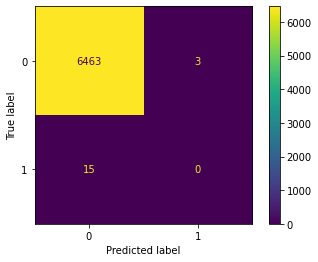

In [ ]:
ConfusionMatrixDisplay.from_estimator(gb_sparse, x_test_freq, y_test_freq)

In [ ]:
#sparse gb_model is very poor  
metric_scoring(gb_sparse, x_test_freq, y_test_freq)

{'Accuracy': 0.9972226508254899,
 'F1 Score': 0.0,
 'Precision': 0.0,
 'Recall': 0.0}

###Gradient Boost Iteration 3, less sparse model, still lags

In [ ]:
#third iteration of GB model, now adding back more features and only taking out '0' weight vars
x_train_freq, x_test_freq, y_train_freq, y_test_freq = train_test_split(input_vector, y, random_state=0, test_size = .20)

In [ ]:
x_train_freq = freq_code(x_train_freq)
x_train_freq = drop_more_cols(x_train_freq)

In [ ]:
x_train_freq.drop(columns = ['CrossStreet', 'StreetName', 'alcohol_involved', 
                             'median_age'], axis = 1, inplace = True)

In [ ]:
gb_sparse2 = GradientBoostingClassifier()

gb_sparse2.fit(x_train_freq, y_train_freq)

GradientBoostingClassifier()

In [ ]:
x_test_freq = freq_code(x_test_freq)
x_test_freq = drop_more_cols(x_test_freq)

#dropping gender and sparse features
x_test_freq.drop(columns = ['CrossStreet', 'StreetName', 'alcohol_involved', 
                             'median_age'], axis = 1, inplace = True)

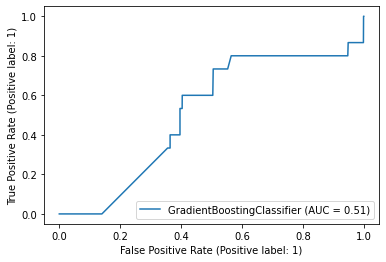

In [ ]:
#performance improves but still lags behind baseline model
RocCurveDisplay.from_estimator(gb_sparse2, x_test_freq, y_test_freq)

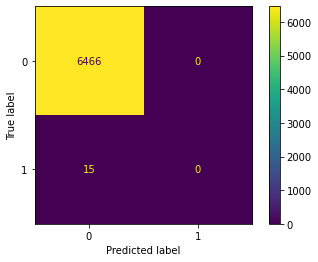

In [ ]:
ConfusionMatrixDisplay.from_estimator(gb_sparse2, x_test_freq, y_test_freq)

### Catboost Iteration 2, sparse model

In [ ]:
#prepping the data, getting rid of useless features
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(input_vector, y, random_state=0, test_size = .20)

x_train_cat, x_val_cat, y_train_cat, y_val_cat = train_test_split(x_train_cat, y_train_cat, test_size=0.20, random_state=0)

#dropping more useless columns in this case the drug and alchol ones related to drivers for cat boost data
x_train_cat = drop_more_cols(x_train_cat)
x_train_cat.drop(columns = ['CrossStreet', 'StreetName'], inplace = True)

x_val_cat = drop_more_cols(x_val_cat)
x_val_cat.drop(columns = ['CrossStreet', 'StreetName'],inplace = True)


In [ ]:
categorical_features_indices = np.where(x_train_cat.dtypes != float)[0]


In [ ]:
catBoost2 = CatBoostClassifier()


In [ ]:
#fitting model
catBoost2.fit(
    x_train_cat, y_train_cat, cat_features=categorical_features_indices, 
    eval_set = (x_val_cat, y_val_cat), plot=True)

In [ ]:
#preprocessing test data, after training process
x_test_cat = drop_more_cols(x_test_cat)
x_test_cat.drop(columns = ['CrossStreet', 'StreetName'], inplace = True)

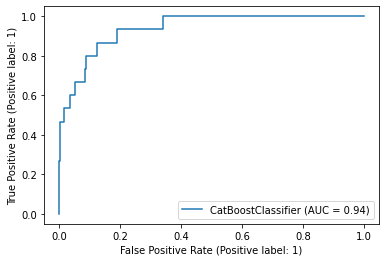

In [ ]:
#AUC Increased
ocCurveDisplay.from_estimator(catBoost2, x_test_cat, y_test_cat)

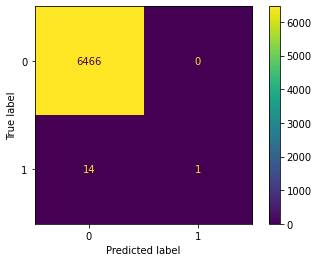

In [ ]:
ConfusionMatrixDisplay.from_estimator(catBoost2, x_test_cat, y_test_cat)

<Figure size 20000x10000 with 0 Axes>

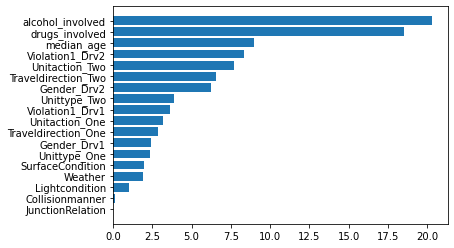

<Figure size 20000x10000 with 0 Axes>

In [ ]:
cat_features = catBoost2.feature_importances_
plt.barh(x_train_cat.columns, sorted(catBoost2.feature_importances_))
figure(figsize=(40, 20), dpi=500)

### Since we saw a slight increase with the sparse cat boost model, we will mive forward and conduct:
  1. Undersampling (Near Miss)
  2. Oversampling (SMOTE)

These methods will be needed in order to try and solve the clear imbalanced class problem

In [197]:
#this method combines SMOTENC to oversample then utilizes, undersampling to clean noisy additions to the dataset
from imblearn.over_sampling import SMOTENC

#prepping the data, getting rid of useless features
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(input_vector, y, random_state=0, test_size = .20)

#dropping more useless columns in this case the drug and alchol ones related to drivers for cat boost data
x_train_cat = drop_more_cols(x_train_cat)
x_train_cat.drop(columns = ['CrossStreet', 'StreetName'], inplace = True)

categorical_features_indices = np.where(x_train_cat.dtypes != float)[0]
catboost3 = CatBoostClassifier(scale_pos_weight= 500)

#smote_nc = SMOTENC(random_state=0, categorical_features = categorical_features_indices, sampling_strategy= (4000/25859))

In [181]:
#oversampling classes
#x_train_cat_res, y_train_cat_res = smote_nc.fit_resample(x_train_cat, y_train_cat)

In [198]:
y_train_cat_res.value_counts()

0    25859
1     3999
Name: Fatal_Non_Fatal, dtype: int64

In [ ]:
#fitting on oversampled data
catboost3.fit(
    x_train_cat, y_train_cat, cat_features=categorical_features_indices, 
     plot=True)

In [200]:
#preprocessing test predictors
x_test_cat = drop_more_cols(x_test_cat)
x_test_cat.drop(columns = ['CrossStreet', 'StreetName'], inplace = True)

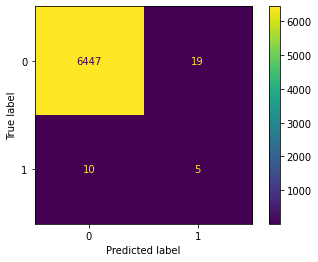

In [201]:
#slight increase in performance but imbalance problem still persists
ConfusionMatrixDisplay.from_estimator(catboost3, x_test_cat, y_test_cat)

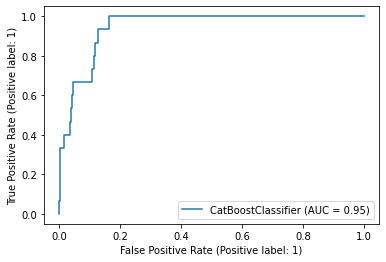

In [202]:
RocCurveDisplay.from_estimator(catboost3, x_test_cat, y_test_cat)

In [203]:
#model still reports poor performance
metric_scoring(catboost3, x_test_cat, y_test_cat)

{'Accuracy': 0.9955253818855115,
 'F1 Score': 0.25641025641025644,
 'Precision': 0.20833333333333334,
 'Recall': 0.3333333333333333}

### Catboost Iteration 4

In [39]:
#using weights for classes 
#this method combines SMOTENC to oversample then utilizes, undersampling to clean noisy additions to the dataset
from imblearn.over_sampling import SMOTENC

#prepping the data, getting rid of useless features
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(input_vector, y, random_state=0, test_size = .20)

#dropping more useless columns in this case the drug and alchol ones related to drivers for cat boost data
x_train_cat = drop_more_cols(x_train_cat)
x_train_cat.drop(columns = ['CrossStreet', 'StreetName'], inplace = True)

categorical_features_indices = np.where(x_train_cat.dtypes != float)[0]
catboost4 = CatBoostClassifier(cat_features=categorical_features_indices, scale_pos_weight=400)

smote_nc = SMOTENC(random_state=0, categorical_features = categorical_features_indices, sampling_strategy= (2500/25859))

In [40]:
#oversampling classes
x_train_cat_res, y_train_cat_res = smote_nc.fit_resample(x_train_cat, y_train_cat)

In [ ]:
#fitting the model 
#catboost4.fit(
 #   x_train_cat_res, y_train_cat_res, cat_features=categorical_features_indices, 
  #  plot=False)

In [41]:
#setting up gridsearch for hyperparameter optimization 
grid = {'learning_rate': [0.03, 0.1, 0.5, 0.8],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9, 12, 15]
        
        }


In [ ]:
#fitting grid search onto our model, do not run without sufficient GPU / compute power
grid_search_result = catboost4.grid_search(grid,
                                       X=x_train_cat_res,
                                       y=y_train_cat_res,
                                       cv = 5,
                                       stratified = True,
                                       plot=True)

In [53]:
#optimal params chosen by grid search
params = catboost4.get_params()
display(params)

{'cat_features': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17]),
 'depth': 10,
 'l2_leaf_reg': 7,
 'learning_rate': 0.1,
 'scale_pos_weight': 400}

In [43]:
#preprocessing test predictors
x_test_cat = drop_more_cols(x_test_cat)
x_test_cat.drop(columns = ['CrossStreet', 'StreetName'], inplace = True)

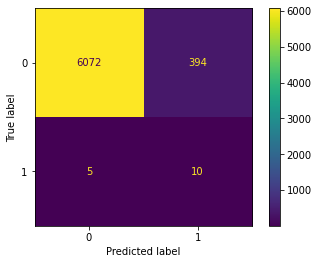

In [49]:
ConfusionMatrixDisplay.from_estimator(catboost4, x_test_cat, y_test_cat)

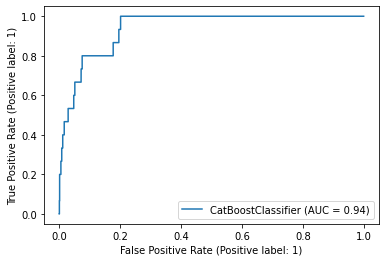

In [45]:
RocCurveDisplay.from_estimator(catboost4, x_test_cat, y_test_cat)

In [46]:
metric_scoring(catboost4, x_test_cat, y_test_cat)

{'Accuracy': 0.9384354266316927,
 'F1 Score': 0.0477326968973747,
 'Precision': 0.024752475247524754,
 'Recall': 0.6666666666666666}

<Figure size 20000x10000 with 0 Axes>

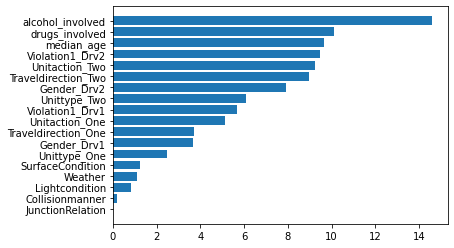

<Figure size 20000x10000 with 0 Axes>

In [47]:
cat_features = catboost4.feature_importances_
plt.barh(x_train_cat.columns, sorted(catboost4.feature_importances_))
figure(figsize=(40, 20), dpi=500)

### Catboost 5

In [169]:
#model performance increased only by a little bit however we will know try different variations of the optimal
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(input_vector, y, random_state=0, test_size = .20)

#dropping more useless columns in this case the drug and alchol ones related to drivers for cat boost data
x_train_cat = drop_more_cols(x_train_cat)
x_train_cat.drop(columns = ['CrossStreet', 'StreetName'], inplace = True)

categorical_features_indices = np.where(x_train_cat.dtypes != float)[0]
catboost5 = CatBoostClassifier(cat_features=categorical_features_indices, scale_pos_weight=400, 
                               depth = 10, l2_leaf_reg = 7, learning_rate = 0.1)

#smote_nc = SMOTENC(categorical_features = categorical_features_indices, sampling_strategy=0.5)

In [170]:
#oversample with smote 
#x_train_cat_res, y_train_cat_res = smote_nc.fit_resample(x_train_cat, y_train_cat)

In [171]:
#undersample with random undersampler
from imblearn.under_sampling import RandomUnderSampler
#rus = RandomUnderSampler(sampling_strategy =  1)

In [172]:
#now undersampling the oversampled data
#X_res, y_res = rus.fit_resample(x_train_cat_res, y_train_cat_res)

In [173]:
y_res.value_counts()

0    12929
1    12929
Name: Fatal_Non_Fatal, dtype: int64

In [ ]:
catboost5.fit(x_train_cat, y_train_cat)

In [175]:
#preprocessing test predictors
x_test_cat = drop_more_cols(x_test_cat)
x_test_cat.drop(columns = ['CrossStreet', 'StreetName'], inplace = True)

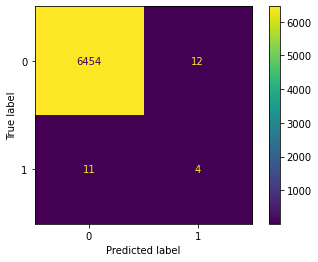

In [178]:
ConfusionMatrixDisplay.from_estimator(catboost5, x_test_cat, y_test_cat)

In [179]:
metric_scoring(catboost5, x_test_cat, y_test_cat)

{'Accuracy': 0.9964511649436816,
 'F1 Score': 0.2580645161290323,
 'Precision': 0.25,
 'Recall': 0.26666666666666666}